# 利用决策树研究在建模期间做出的特征
    首先应该在二分类上进行探索性分析，根据提取出来的特征判断是否（会）违约，然后再拿这些特征去尝试四分类的情景。
    
    这样做的好处之一是我们方便对二分类的特征分布和其对标签之间的关系做出可视化。
    
    一步一步的来，不要一上来就对四分类进行尝试。

In [1]:
import sklearn
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import numpy as np 

# 这两行代码用于辅助后面的图例的汉字正常显示
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

加载标签,同时计算违约的与不违约的比例，发现数据有较明显的偏斜，没有违约的占据大多数,违约的实际上有27个

In [2]:
# 加载标签
labels_without_onehot = pd.read_csv("Cleaned_data\label_without_one_hot.csv",index_col=0,encoding='gb18030')
labels = labels_without_onehot['是否违约']
rate = labels.sum() / len(labels)
rate

0.21951219512195122

In [3]:
# 使用以前提取出来的特征,不见得是对的。但是可以先跑一跑整个项目
X_old = pd.read_csv("Data\建模期间的特征.csv",index_col=0)

切分训练集和测试集

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_old, labels)

使用决策树进行测试,准确率的波动相当得大,且多数时候效果并不好

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train) 
score = tree_clf.score(X_test, y_test)
score

0.7741935483870968

In [6]:
from sklearn.metrics import confusion_matrix

决策树有一个参数设置是决策树的最大深度max_depth

默认可以不输入，如果不输入的话，决策树在建立子树的时候不会限制子树的深度。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。

可以看出来，也许我们构建出来的特征还是太少了，我都没有限制深度学习效果都在多数时候都很差，这说明我们还有很多的东西没有从原始数据中挖掘出来

下面可视化一下树的节点，发现在sklearn的2.1.0版本以后吧，可以用plot_tree的方式，利用matplotlib将决策树可视化。效果还不错

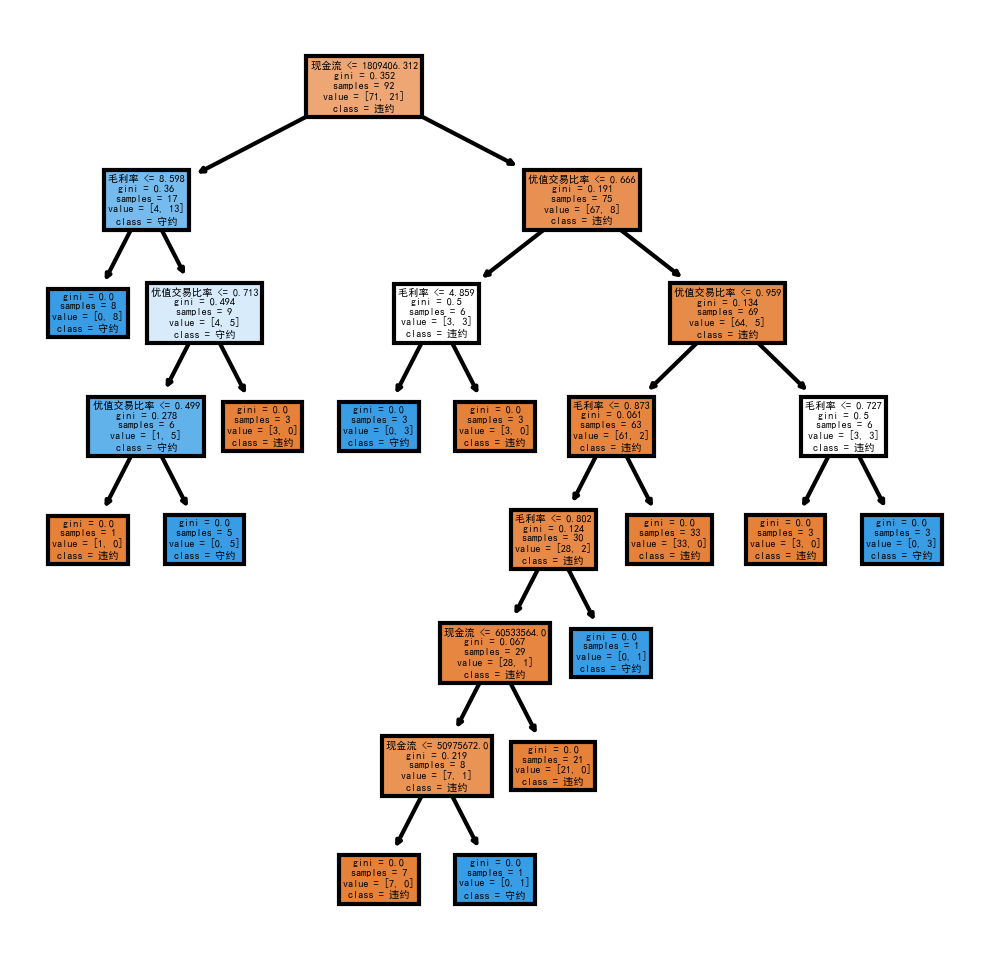

In [7]:
# fn是feature_name的简称
fn = list(X_old.columns)
#cn是class_name的简称
cn = ['违约','守约']
# 设置子图的具体细节
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
sklearn.tree.plot_tree(tree_clf,feature_names=fn,class_names=cn,filled=True)
plt.show()

emmm,可以看到这个东西不是很理想丫,我们进一步地把混淆矩阵打出来看看

而且从这里就能看出一点端倪了，比较有区分度的特征是现金流和毛利率，至于供求关系稳定程度，这个东西在我运行的时候就没有出现过

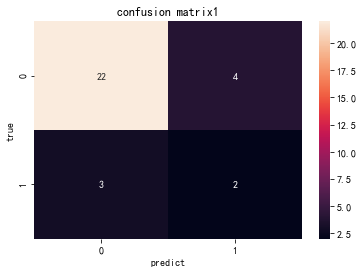

In [8]:
from sklearn.metrics import confusion_matrix
Confusion_Matrix1 = confusion_matrix(tree_clf.predict(X_test),y_test)
# 画热力图，把混淆矩阵变得好看一点
f,ax=plt.subplots()
sns.heatmap(Confusion_Matrix1,annot=True,ax=ax)
ax.set_title('confusion matrix1') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.show()

精准率

In [9]:
from sklearn.metrics import precision_score
precision_score(tree_clf.predict(X_test),y_test)

0.3333333333333333

召回率

In [10]:
from sklearn.metrics import recall_score
recall_score(tree_clf.predict(X_test),y_test)

0.4

但是如果我设定好一个随机种子，这几个指标会发生明显的变化,这是决策树的通病吧。对数据的不同的切分方式可能会生成截然不同的决策树模型

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_old, labels,random_state=42)
tree_clf.fit(X_train, y_train) 
score = tree_clf.score(X_test, y_test)
score

0.9032258064516129

精准率和召回率我就不打印了，和上面的流程是一样的，这里只是展示混淆矩阵，能看出来可能效果比上面要好很多，但是看图也知道过拟合了

但是对训练集和测试集的切分对最终结果按理说不应该有这么大的区别。

In [12]:
Confusion_Matrix2 = confusion_matrix(tree_clf.predict(X_test),y_test)
Confusion_Matrix2

array([[26,  3],
       [ 0,  2]], dtype=int64)

可视化看看

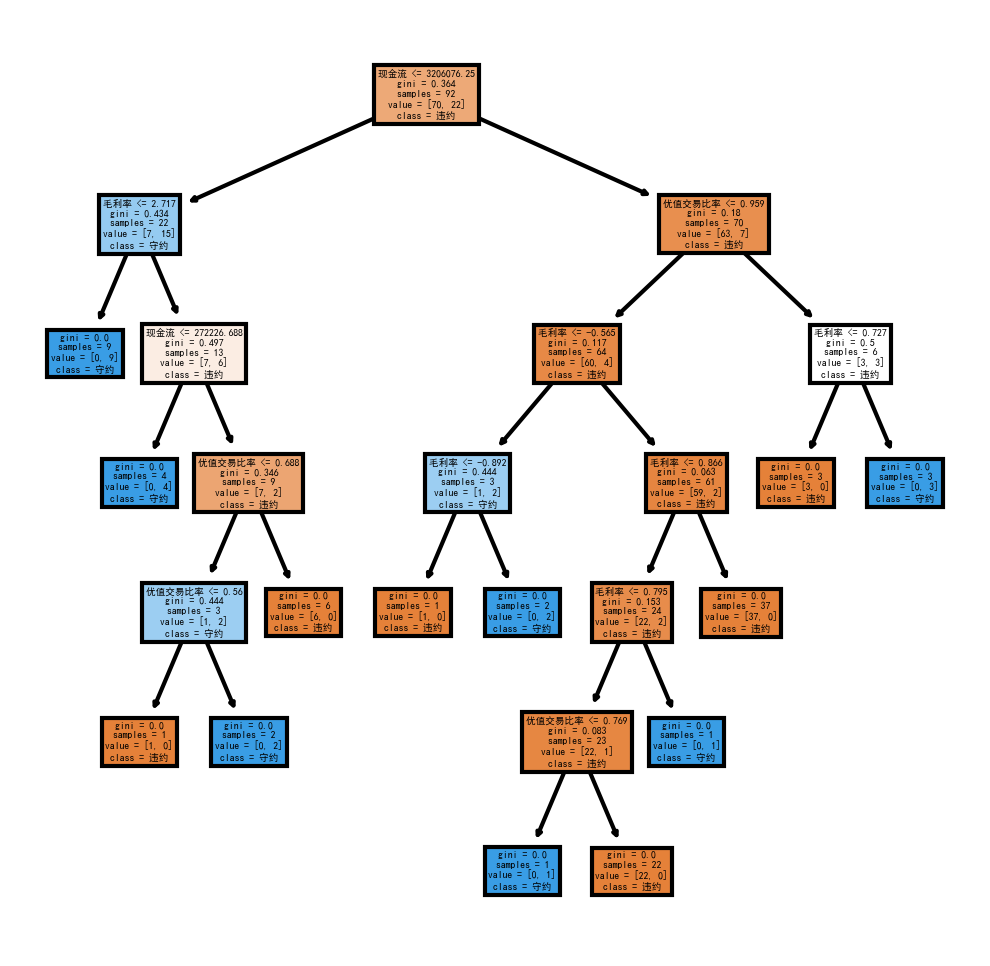

In [13]:
# fn是feature_name的简称
fn = list(X_old.columns)
#cn是class_name的简称
cn = ['违约','守约']
# 设置子图的具体细节
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
sklearn.tree.plot_tree(tree_clf,feature_names=fn,class_names=cn,filled=True)
plt.show()

研究一下,不管是哪颗决策树，都把现金流记为了第一区分度的标准，其次两棵树都出现的，有第二区分度的是毛利率。

优值交易比率出现的次数和重要程度都并不是很理想。可能要尝试着再修改一下这个特征的处理方式。在后面的决策树中供求稳定程度就没有出现过

另外，如果你们再仔细看一下附件1的数据发现这个发票的数据是有年份区分的。也就是说有些企业可能有三年的发票信息，但是有些企业只有一年的信息，而这个细节是我当时没有考虑到的。这次要考虑进去。

所以我们首先的问题可能是特征的数量就不够多，其次特征不能很好地提取信息可能也是个问题，那么这就是我们下一步大概要走的方向

再打印出每个特征的重要程度来看，可以看到营收规模和供求稳定程度真的是一点用都没有2333

In [14]:
tree_clf.feature_importances_

array([0.        , 0.34861048, 0.4385901 , 0.21279942, 0.        ])

In [15]:
X_old.columns

Index(['营收规模', '毛利率', '现金流', '优值交易比率', '供求稳定程度'], dtype='object')